# Notebook 6 - Putting it all together

Although in this notebook we will not go over new topics, we are going to see how we can fully handle a text sentiment classification task. We are going to use many different techniques covered in previous notebooks, that (hopefully) let us develop quite an efficient model. Additionally, we are going to create some visualizations of dataset statistics and model performance, so we can understand the problem better.

We are going to use the dataset containing tweets about US airlines from [kaggle](). The dataset is stored in the CSV file `airline_tweets.csv` and contains tweet text labeled with either *"positive"*, *"neutral"* or *"negative"* sentiment. Besides, it contains (potentially) helpful information like the name of the airline and the user’s location. Let's explore it!

In [1]:
!pip install swifter
!pip install langdetect

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from langdetect import detect
import seaborn as sns
import spacy
import en_core_web_sm
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/lisanka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lisanka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data preprocessing & feature engineering

## Dataset overview

In [156]:
dataset_file = "https://raw.githubusercontent.com/TheRootOf3/ucl-nlp-notebook-series/main/Notebook6/datasets/airline_tweets.csv"

''' uncomment if you want to run it locally '''
# dataset_file = "./datasets/airline_tweets.csv"

df_tweets = pd.read_csv(dataset_file)

In [157]:
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Ok, so there are many columns with additional information. However, some of their fields are empty. To determine whether we want to include a certain column in the further analysis, we may want to inspect how many fields in these columns are null. Let's do it using the `.info()` method.

In [158]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Ok, now we have an overview of the dataset and we can see that columns like `airline_sentiment_gold` or `tweet_coord` are generally empty (contain null values). How about columns like `tweet_location` or `user_timezone`? We can inspect them visually and see if "null" values are stacked or randomly scattered throughout the whole dataset.

<AxesSubplot:>

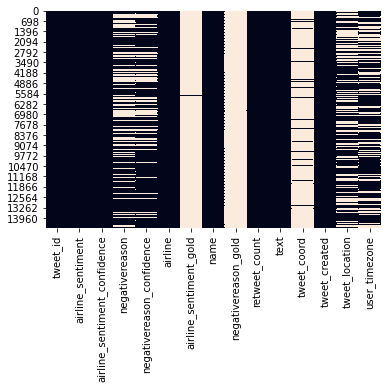

In [159]:
sns.heatmap(df_tweets.isnull(), cbar=False)

In our study, besides "text" and "airline_sentiment" we will use the "airline" and "tweet_location" columns.

In [160]:
df = df_tweets[[ "airline_sentiment", "airline", "text", "tweet_location"]]

In [161]:
df.head()

,airline_sentiment,airline,text,tweet_location
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,NaN
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,NaN
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,NaN
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,NaN


---

## Baseline classification on raw data

Now, let's train the Naive-Bayes classifier without any preprocessing or parameter tuning, and let's see what accuracy score we get.

In [162]:
X_train, X_test, y_train, y_test = train_test_split(df_tweets.text, df_tweets.airline_sentiment, test_size=0.2, 
                                                                                random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1,1),binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [163]:
mnb = MultinomialNB()
mnb.fit(X_train_counts, y_train)

MultinomialNB()

In [164]:
y_predicted_counts = mnb.predict(X_test_counts)

In [165]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.771, precision = 0.767, recall = 0.771, f1 = 0.746


It seems like even without much work we can get not bad results! Let's verify them using cross-validation.

In [166]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(mnb, X_train_counts, y_train, cv=5)

In [167]:
scores.mean()

0.7596467191733065

Ok, so the baseline classifier ran on the totally unprocessed dataset gives us **around 76% accuracy** using cross-validation. We will come back to this number later!

From now we aim to get a higher accuracy score. We are going to preprocess data, extract some features and work on the model parameters selection, so all of this work will hopefully let us get better results.

## Further dataset exploration

Let's see what is the structure of the dataset in terms of the airline and sentiment.

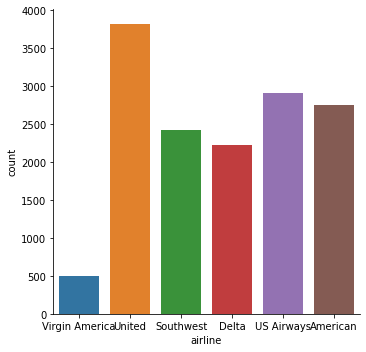

In [168]:
sns.catplot(x="airline",kind="count", data=df)

In terms of airlines, the situation doesn't look very bad except for the low number of tweets regarding Virgin America.

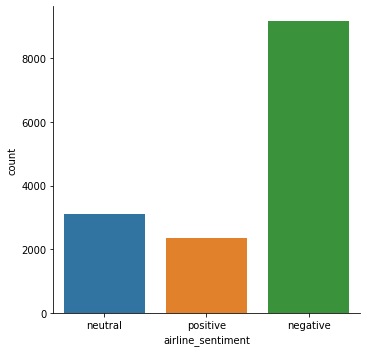

In [169]:
sns.catplot(x="airline_sentiment", kind="count", data=df)

However, when it comes to sentiment, we can see that the dataset is highly imbalanced. We have much more negative tweets than neutral or positive ones. Often the result of such imbalance is the lower accuracy. To partially solve this issue we may want to *resample* the dataset later.

We may also want to see what is the sentiment statistic for each airline.

/home/lisanka/anaconda3/envs/ml2021/lib/python3.8/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


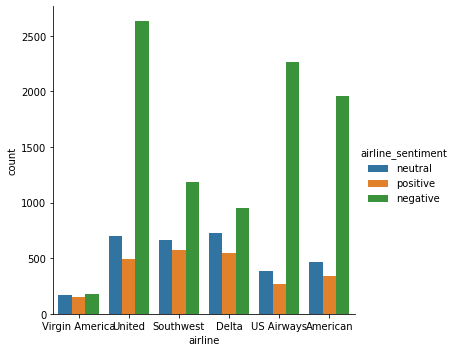

In [170]:
sns.factorplot("airline", data=df, hue="airline_sentiment", kind="count")

What we can read from this plot? Actually quite useful information! We can see that the airline people tweet about has an influence on the tweet sentiment. For example, the great majority of all tweets about United Airlines are negative. On the other hand, neutral and positive tweets regarding Delta Airlines outnumber negative samples. Hence, we will want to treat the tweet-related airline as a feature.

---

## Feature extraction - airline 

So how can we use the name of the airline as a feature? One way is to add it at the end of the text. By doing so, we will give a classifier a "hint", that is related to the sentiment. Interestingly, since every tweet mentions one of 6 airlines, they already contain airlines names in the beginning! Let's make sure that it is true for all tweets.

In [171]:
df_starting_word = df["text"].apply(word_tokenize)
pd.Series(x[1].lower() for x in df_starting_word).value_counts().head(10)

united           3724
usairways        2863
americanair      2690
southwestair     2378
jetblue          1999
virginamerica     486
@                 251
“                  13
!                  13
,                  12
dtype: int64

As you can see, the great majority of all tweets start with the airline name. Some tweets do not, but we will ignore them since these are rare cases. In the preprocessing, we will remove "@" characters and make all words lowercase so we will treat "united" and "United" as the same token. Also, what is interesting, the original dataset seems to be broken - there are no tweets regarding "Delta", however, there is "JetBlue" instead.

Hence, we can drop the "airline" column, since we will not use it anymore.

In [172]:
del df["airline"]
df

,airline_sentiment,text,tweet_location
0,neutral,@VirginAmerica What @dhepburn said.,NaN
1,positive,@VirginAmerica plus you've added commercials t...,NaN
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,negative,@VirginAmerica it's really aggressive to blast...,NaN
4,negative,@VirginAmerica and it's a really big bad thing...,NaN
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,NaN
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,Texas
14637,neutral,@AmericanAir Please bring American Airlines to...,"Nigeria,lagos"
14638,negative,"@AmericanAir you have my money, you change my ...",New Jersey


## Feature extraction - location

We can also extract the location from the "tweet_location" column. One may think that since the column already exists, the only thing we need to do is to match it with the label column. In this case, this won't work, since the "tweet_location" column contains geographical names in different formats, sometimes contains even more than one location. We are going to extract them from the column using the `SpaCy` English language model - "en_core_web_sm" (already downloaded in the Notebook 3).

We have already seen named-entity recognition in Notebook 2, so let's apply it here. We will extract all geographical entities (GPE). Let's see the example below.

In [173]:
text="San Mateo, CA & Las Vegas, NV"
NLP = en_core_web_sm.load()
output = NLP(text)
for item in output.ents:
    print(item.label_, item)

GPE San Mateo
ORG CA & Las Vegas
ORG NV


Now, let's create a function, that given a text from the "tweet_location" column returns all found GPE names. If the column field is empty, the function will return "nolocationplaceholder" to consistently specify the lack of the location.

In [174]:
def filter_location(text):
    if text == "":
        return "nolocationplaceholder"
    else:
        try:
            output = NLP(text)
            locations = []
            for item in output.ents:
                if item.label_ == "GPE":
                    locations.append(str(item))
            if not len(locations):
                return "nolocationplaceholder"
            return locations
        except:
            return "nolocationplaceholder"

Let's create a special series in the dataframe for the extracted locations list (or nolocationplaceholder).

In [175]:
df["location_ner"] = df.tweet_location.swifter.apply(filter_location)

<ipython-input-175-05ae386a55a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["location_ner"] = df.tweet_location.swifter.apply(filter_location)


In [176]:
df

,airline_sentiment,text,tweet_location,location_ner
0,neutral,@VirginAmerica What @dhepburn said.,NaN,nolocationplaceholder
1,positive,@VirginAmerica plus you've added commercials t...,NaN,nolocationplaceholder
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Lets Play,nolocationplaceholder
3,negative,@VirginAmerica it's really aggressive to blast...,NaN,nolocationplaceholder
4,negative,@VirginAmerica and it's a really big bad thing...,NaN,nolocationplaceholder
...,...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,NaN,nolocationplaceholder
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,Texas,[Texas]
14637,neutral,@AmericanAir Please bring American Airlines to...,"Nigeria,lagos",[Nigeria]
14638,negative,"@AmericanAir you have my money, you change my ...",New Jersey,[New Jersey]


However, we would like to have each extracted location in a specific column.

In [177]:
location_df = df["location_ner"].apply(pd.Series)
location_df

,0,1,2,3
0,nolocationplaceholder,NaN,NaN,NaN
1,nolocationplaceholder,NaN,NaN,NaN
2,nolocationplaceholder,NaN,NaN,NaN
3,nolocationplaceholder,NaN,NaN,NaN
4,nolocationplaceholder,NaN,NaN,NaN
...,...,...,...,...
14635,nolocationplaceholder,NaN,NaN,NaN
14636,Texas,NaN,NaN,NaN
14637,Nigeria,NaN,NaN,NaN
14638,New Jersey,NaN,NaN,NaN


Now some concatenation and renaming...

In [178]:
df = pd.concat([location_df, df], axis=1)

In [179]:
df.rename(columns={0: 'loc_1', 1: 'loc_2', 2: "loc_3", 3: "loc_4"}, inplace="True")

And done!

In [180]:
df

,loc_1,loc_2,loc_3,loc_4,airline_sentiment,text,tweet_location,location_ner
0,nolocationplaceholder,NaN,NaN,NaN,neutral,@VirginAmerica What @dhepburn said.,NaN,nolocationplaceholder
1,nolocationplaceholder,NaN,NaN,NaN,positive,@VirginAmerica plus you've added commercials t...,NaN,nolocationplaceholder
2,nolocationplaceholder,NaN,NaN,NaN,neutral,@VirginAmerica I didn't today... Must mean I n...,Lets Play,nolocationplaceholder
3,nolocationplaceholder,NaN,NaN,NaN,negative,@VirginAmerica it's really aggressive to blast...,NaN,nolocationplaceholder
4,nolocationplaceholder,NaN,NaN,NaN,negative,@VirginAmerica and it's a really big bad thing...,NaN,nolocationplaceholder
...,...,...,...,...,...,...,...,...
14635,nolocationplaceholder,NaN,NaN,NaN,positive,@AmericanAir thank you we got on a different f...,NaN,nolocationplaceholder
14636,Texas,NaN,NaN,NaN,negative,@AmericanAir leaving over 20 minutes Late Flig...,Texas,[Texas]
14637,Nigeria,NaN,NaN,NaN,neutral,@AmericanAir Please bring American Airlines to...,"Nigeria,lagos",[Nigeria]
14638,New Jersey,NaN,NaN,NaN,negative,"@AmericanAir you have my money, you change my ...",New Jersey,[New Jersey]


So what can we do with these extracted location names? We can try to find a relation between the location name and the sentiment of the tweet. Firstly, let's see the top 20 locations.

In [181]:
dict(df.loc_1.value_counts().iloc[:20])

{'nolocationplaceholder': 8488,
 'New York': 401,
 'Washington': 330,
 'Boston': 263,
 'Chicago': 243,
 'Los Angeles': 201,
 'San Francisco': 199,
 'USA': 173,
 'Dallas': 127,
 'New York City': 124,
 'Brooklyn': 108,
 'Austin': 95,
 'Houston': 84,
 'London': 77,
 'San Diego': 72,
 'Denver': 70,
 'Seattle': 68,
 'Nashville': 65,
 'Texas': 61,
 'Philadelphia': 58}

Now, let's see if there is any relation between tweets sentiment and the location. We can 

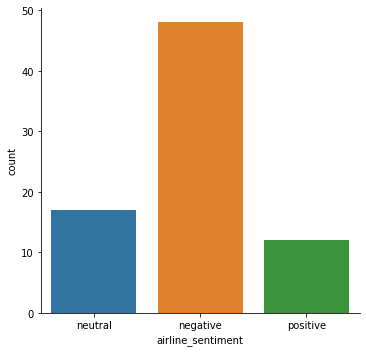

In [182]:
sns.catplot(x="airline_sentiment",kind="count", data=df[df.loc_1 == "London"])

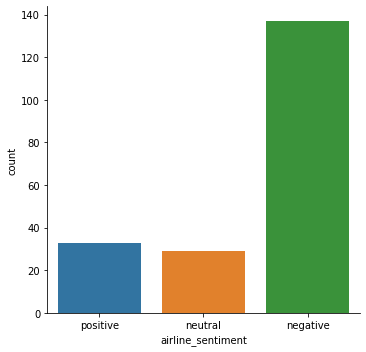

In [183]:
sns.catplot(x="airline_sentiment",kind="count", data=df[df.loc_1 == "San Francisco"])

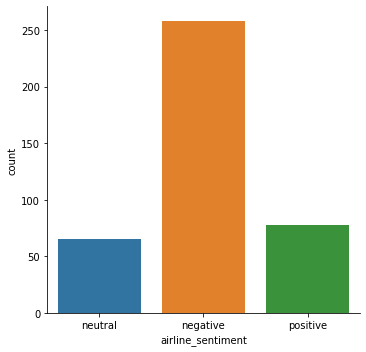

In [184]:
sns.catplot(x="airline_sentiment",kind="count", data=df[df.loc_1 == "New York"])

It seems like there is no big difference from where the tweet was tweeted since the majority seems to be negative. However, let's take loc_1 as a feature and concatenate it with the tweet text.

In [185]:
df["text_loc"] = df["text"].astype(str) + " " + df["loc_1"].astype(str)

Also, now, we can drop all other unused columns and just keep our edited text and the airline_sentiment label.

In [186]:
df = df[["text_loc", "airline_sentiment" ]]

In [187]:
df

,text_loc,airline_sentiment
0,@VirginAmerica What @dhepburn said. nolocation...,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


## Preprocessing and extracting features from text
Now since we have already extracted the precise location of the tweets (if it was an actual geographical location) we can start with the preprocessing of the raw text.

### Language

Firstly, we will start with determining the actual language of each tweet. The fact that 10 tweets from the top and the bottom are in English doesn't mean that all of them are! We don't want to mix languages since the same words often repeat in different languages and may have different meanings. To detect the language of each tweet we will use the `langdetect` package.

In [ ]:
df['language'] = df["text_loc"].swifter.apply(detect)

In [ ]:
df.language.value_counts()

In [ ]:
df[df.language =="it"]

In [ ]:
df[df.language =="fr"]

It seems like the langdetect was mistaken and the majority of all tweets is actually in English, so **let's not delete anything**.

### Emojis

One interesting text-based feature that can be extracted is the occurrence of emojis with a negative/positive meaning. The intuition behind this is to develop a list of negative emojis and if a tweet contains one of them, mark that tweet with a certain token, that the classifier will (hopefully) relate with the negative sentiment. However, before treating it as a feature we should check if it is related to the sentiment.

To start, we need a way of extracting emojis from the text. Let's explore the example below. 

In [ ]:
!pip install emoji

In [188]:
import emoji
from emoji import UNICODE_EMOJI
import re

example_emoji_sentence = "@VirginAmerica 👍 Need to start flying to @KCIAirport .  😊😀😃😄"

def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

In [189]:
extract_emojis(example_emoji_sentence)

'👍😊😀😃😄'

We may want to explore what kind of emojis and how joined together occur in our dataset.

In [190]:
emojis_ = []

In [191]:
corpus = df.text_loc.tolist()
for i in corpus:
    h = extract_emojis(i)
    if len(h) != 0:
        emojis_.append(h)

In [192]:
emojis_

['❤☺👍',
 '😡',
 '😢',
 '💜✈',
 '🍷👍💺✈',
 '😊',
 '😍👌',
 '💕💕',
 '🌞✈',
 '😃',
 '😩😭',
 '😎',
 '🙉',
 '😁',
 '❤',
 '❄❄❄',
 '👏',
 '😂💗',
 '🍸',
 '😒',
 '👎',
 '👍👍✈✈💗',
 '😊😀😃😄',
 '😎',
 '😘',
 '👸💗',
 '😁😁😁',
 '😍💗💗💗🎀🌏🎀',
 '😥',
 '🎀🎀🎀',
 '😉',
 '😍😍✨😱✈',
 '✈🎉',
 '💗🎀💗',
 '😃👍',
 '😁',
 '🙌💤',
 '😡',
 '😞',
 '♥',
 '👋',
 '😢',
 '✌',
 '🙏',
 '❤',
 '🙌',
 '💜',
 '✈',
 '❄❄',
 '😃😃😃',
 '👿',
 '😉😉',
 '😔',
 '😭',
 '😊',
 '🙌🙌',
 '🙅🙅🙅',
 '😉😉😉',
 '✈',
 '👎',
 '❤',
 '😡😡',
 '❤',
 '❤',
 '❤',
 '👏👏👏✈',
 '👍',
 '❤',
 '🆖',
 '😢',
 '💩',
 '✔',
 '🌴🌴',
 '✅❌',
 '😡',
 '😊',
 '👏👏👏👏👏👏',
 '👍',
 '👍',
 '👏👏',
 '🙏',
 '😄😄😄😡😡😡',
 '😒',
 '👠👠👠',
 '😜',
 '👍',
 '👏👏',
 '😞',
 '😡',
 '😊',
 '🎉🎉🎉',
 '😔',
 '😊',
 '😻😻😻',
 '😊😕',
 '👎',
 '😭',
 '👍',
 '👌',
 '😉',
 '😢',
 '👎👎',
 '😈',
 '😡',
 '😊',
 '👎',
 '😉',
 '😡😡😡😡😤😤😤',
 '❄',
 '👏👏👏',
 '👍😊',
 '❤',
 '😔',
 '👍👌',
 '😂',
 '😊',
 '😀',
 '😭',
 '👌',
 '💪',
 '😉',
 '😩😫😢',
 '💔😪',
 '😕',
 '😣',
 '😬',
 '👍',
 '😄',
 '👏👏👏',
 '😂💁',
 '😋',
 '🙌😏',
 '😖',
 '🌟🌟',
 '✈',
 '👍',
 '✈📱',
 '😞',
 '👏👏🍻🍻',
 '👎',
 '😞😡',
 '💖',
 '😂😂😂😂😂😭😭😭😭😢😢😢😢',
 '😅',
 '😔😔😔',
 '😢',
 '💝',
 '🚫↔',

Let's create a list of emojis with negative meanings and develop a function that will return the "negemoji" token if there is a negative emoji in the tweet text.

In [193]:
neg_emojis = "😭,🆘, 😡, 😩, 😞, 😢, 👿, 👎, 😔, 😪, 😫, 😤, 😖, 😠, 💩, 😑, 😕, 😒"

def contains_neg_emoji(text):
    emojis =  ''.join(c for c in text if c in emoji.UNICODE_EMOJI['en'])
    contains_neg = ""
    for e in emojis:
        if e in neg_emojis:
            contains_neg = "negemoji"
            
    return contains_neg

In [194]:
df["neg_emoji"] = df.text_loc.apply(contains_neg_emoji)

<ipython-input-194-6d7014106903>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neg_emoji"] = df.text_loc.apply(contains_neg_emoji)


Ok, now let's see how many tweets actually have negative emojis.

In [195]:
df.neg_emoji.value_counts()

            14496
negemoji      144
Name: neg_emoji, dtype: int64

Only 1% of all tweets contain negative emojis!  Let's check the relation between negative emojis and the sentiment of the tweet.

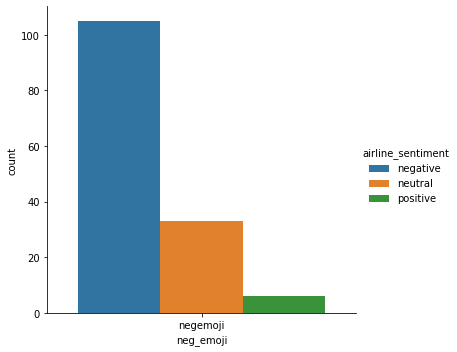

In [196]:
sns.catplot("neg_emoji", data=df[df["neg_emoji"] == 'negemoji'], hue="airline_sentiment", kind="count")

However, the relation between containing negative emoji and the sentiment of a tweet looks very good - there is a very small number of positive-labeled tweets containing a negative emoji. 

In [197]:
df

,text_loc,airline_sentiment,neg_emoji
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,
1,@VirginAmerica plus you've added commercials t...,positive,
2,@VirginAmerica I didn't today... Must mean I n...,neutral,
3,@VirginAmerica it's really aggressive to blast...,negative,
4,@VirginAmerica and it's a really big bad thing...,negative,
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,
14637,@AmericanAir Please bring American Airlines to...,neutral,
14638,"@AmericanAir you have my money, you change my ...",negative,


The occurrence of negative emojis probably won't help much since it occurs in only 1% of all tweets but let's still implement it as a feature!

In [198]:
df["text_loc"] = df["text_loc"].astype(str) + " " + df["neg_emoji"].astype(str)

<ipython-input-198-4b5579c8cdf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_loc"] = df["text_loc"].astype(str) + " " + df["neg_emoji"].astype(str)


In [199]:
df = df[["text_loc", "airline_sentiment"]]

In [200]:
df

,text_loc,airline_sentiment
0,@VirginAmerica What @dhepburn said. nolocation...,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


## Further feature extraction - urls, numbers, hashtags...

Here, we are going to extract more features from the text. If we research that a specific feature discriminates well (is related to the positive or negative sentiment), we will mark a tweet with a specific token - as previously.

### URLs

In [201]:
import re
def contains_link(text):
    text = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     text)
    text = word_tokenize(text)
    if "httpaddr" in text:
        return "YES"
    else:
        return "NO"

In [202]:
df["contains_link"] = df.text_loc.apply(contains_link)

/home/lisanka/anaconda3/envs/ml2021/lib/python3.8/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


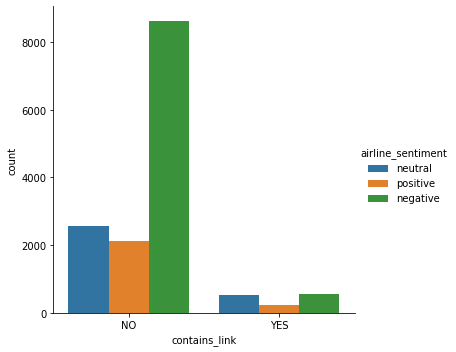

In [203]:
sns.factorplot("contains_link", data=df, hue="airline_sentiment", kind="count")

### Numbers

In [204]:
def contains_number(text):
        
    text = re.sub(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'numbr',
                     text)
    
    text = re.sub(r'\d+(\.\d+)?', 'numbr',
                     text)
    text = word_tokenize(text)
    if "numbr" in text:
        return "YES"
    else:
        return "NO"

In [205]:
df["contains_number"] = df.text_loc.apply(contains_number)

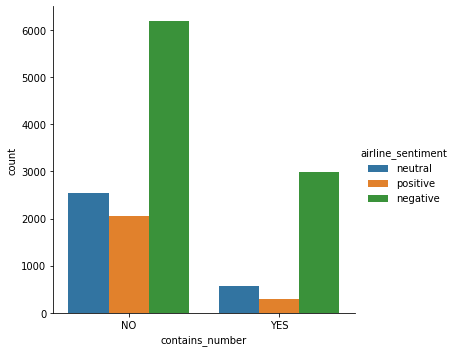

In [206]:
sns.factorplot("contains_number", data=df, hue="airline_sentiment", kind="count")

### Hashtags

In [207]:
def contains_hashtag(text):
        
    text = re.sub(r'\b#w+\b', 'hashtg',
                     text)
    
    text = re.sub(r'\d+(\.\d+)?', 'hashtg',
                     text)
    text = word_tokenize(text)
    if "hashtg" in text:
        return "YES"
    else:
        return "NO"

In [208]:
df["contains_hashtag"] = df.text_loc.apply(contains_hashtag)

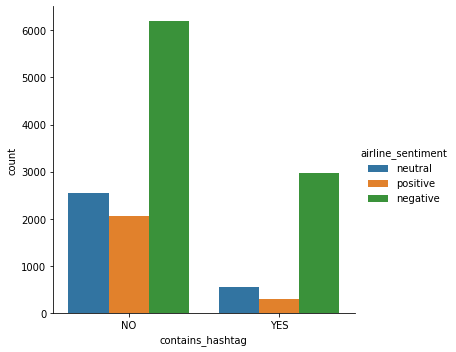

In [209]:
sns.factorplot("contains_hashtag", data=df, hue="airline_sentiment", kind="count")

Sadly, the occurrence of URLs, numbers, or hashtags doesn't seem to have a strong influence on the tweet sentiment. 

## Preprocessing - cleaning

### Standard preprocessing 

Now we need to clean the data. Here, we will replace all URLs, numbers with a standard token. Besides, we are going to remove all punctuation so all mentions and hashtags will become normal words and make all tweets lowercase.

In [210]:
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

# After our quick reserach location also doesn't seem to have 
# a strong influence so we will remove the "nolocationplaceholder" token as well.
stop_words.append("nolocationplaceholder")

# Convert to set, so lookup operations are much faster
stop_words = set(stop_words)

In [211]:
def preprocess(text):

    text = re.sub(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', ' numbr ',
                  text)

    text = re.sub(r'\d+(\.\d+)?', ' numbr ',
                  text)

    text = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', ' httpaddr ',
                  text)

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", text)

    # convert to lower case and split
    words = word_tokenize(letters_only_text.lower())

    # remove stopwords
    cleaned_words = []
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)

    sen = ' '.join(cleaned_words)

    return sen

In [212]:
df["cleaned_text"] =df.text_loc.swifter.apply(preprocess)

In [213]:
df

,text_loc,airline_sentiment,contains_link,contains_number,contains_hashtag,cleaned_text
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,NO,NO,NO,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,NO,NO,NO,virginamerica plus added commercials experienc...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,NO,NO,NO,virginamerica today must mean need take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,NO,NO,NO,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,negative,NO,NO,NO,virginamerica really big bad thing
...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,NO,NO,NO,americanair thank got different flight chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,NO,YES,YES,americanair leaving numbr minutes late flight ...
14637,@AmericanAir Please bring American Airlines to...,neutral,NO,NO,NO,americanair please bring american airlines bla...
14638,"@AmericanAir you have my money, you change my ...",negative,NO,NO,NO,americanair money change flight answer phones ...


### Rare word removal

If a word occurs once or twice in the whole dataset, its occurrence doesn't change much. However, since these words are still "analyzed" by the classifier, they may in fact violate the classification process! It is common to remove such words. Let's start with creating a dictionary of the word counts - basically a term frequency dictionary.

In [214]:
app_desc_clean_list = df["cleaned_text"].tolist()
whole_corpus = " ".join(app_desc_clean_list)

In [215]:
from collections import Counter
rare_words = {} # again, storing it in dictionary instead of list will make looking through it much faster

counter_dic = Counter(whole_corpus.split())

Let's define a word as "rare" if it occurs only once or twice in the corpus.

In [216]:
for (key,value) in counter_dic.items():
    if value < 3:
        rare_words[key] = value

Let's explore which words are actually "rare".

In [217]:
rare_words

{'dhepburn': 1,
 'tacky': 1,
 'blast': 2,
 'obnoxious': 2,
 'ear': 2,
 'worm': 1,
 'parody': 1,
 'grezp': 1,
 'graphics': 1,
 'minimal': 1,
 'iconography': 1,
 'virginmedia': 1,
 'seductive': 1,
 'daystogo': 1,
 'gentleman': 2,
 'amazingly': 2,
 'graphic': 1,
 'grrwaaa': 1,
 'hipster': 1,
 'permanently': 2,
 'vents': 1,
 'noair': 1,
 'sfotobos': 1,
 'mateo': 1,
 'noob': 1,
 'maneuver': 2,
 'sendambien': 1,
 'andchexmix': 1,
 'bked': 1,
 'fe': 2,
 'pacificbiznews': 1,
 'vibe': 2,
 'moodlight': 1,
 'moodlitmonday': 2,
 'sciencebehindtheexperience': 2,
 'unxtqp': 1,
 'moodlighting': 2,
 'calming': 1,
 'freddieawards': 1,
 'gtdwpk': 1,
 'mountains': 2,
 'nf': 1,
 'ibtr': 1,
 'bid': 1,
 'travelhelp': 1,
 'elevategold': 1,
 'drfaoq': 1,
 'khx': 1,
 'tribute': 1,
 'soundofmusic': 1,
 'spotify': 2,
 'guiltypleasures': 1,
 'gaga': 2,
 'bali': 1,
 'indonesia': 1,
 'carrie': 2,
 'meh': 2,
 'martin': 1,
 'minn': 1,
 'classics': 1,
 'heyyyy': 1,
 'guyyyys': 1,
 'travelzoo': 1,
 'iljaebv': 1,
 'loft

In [218]:
len(rare_words)

8680

In [219]:
len(set(corpus))

14455

Now, we can delete them.

In [220]:
def delete_rare_words(text):
    words = word_tokenize(text)

    cleaned_words = []
    
    for word in words:
        if word not in rare_words:
            cleaned_words.append(word)
            
    return ' '.join(cleaned_words)

In [221]:
df["cleaned_text"] = df["cleaned_text"].swifter.apply(delete_rare_words)

In [222]:
df

,text_loc,airline_sentiment,contains_link,contains_number,contains_hashtag,cleaned_text
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,NO,NO,NO,virginamerica said
1,@VirginAmerica plus you've added commercials t...,positive,NO,NO,NO,virginamerica plus added commercials experience
2,@VirginAmerica I didn't today... Must mean I n...,neutral,NO,NO,NO,virginamerica today must mean need take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,NO,NO,NO,virginamerica really aggressive entertainment ...
4,@VirginAmerica and it's a really big bad thing...,negative,NO,NO,NO,virginamerica really big bad thing
...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,NO,NO,NO,americanair thank got different flight chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,NO,YES,YES,americanair leaving numbr minutes late flight ...
14637,@AmericanAir Please bring American Airlines to...,neutral,NO,NO,NO,americanair please bring american airlines numbr
14638,"@AmericanAir you have my money, you change my ...",negative,NO,NO,NO,americanair money change flight answer phones ...


One more thing - if there are any duplicates let's delete them as well.

In [223]:
df = df.drop_duplicates()

In [224]:
df

,text_loc,airline_sentiment,contains_link,contains_number,contains_hashtag,cleaned_text
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,NO,NO,NO,virginamerica said
1,@VirginAmerica plus you've added commercials t...,positive,NO,NO,NO,virginamerica plus added commercials experience
2,@VirginAmerica I didn't today... Must mean I n...,neutral,NO,NO,NO,virginamerica today must mean need take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,NO,NO,NO,virginamerica really aggressive entertainment ...
4,@VirginAmerica and it's a really big bad thing...,negative,NO,NO,NO,virginamerica really big bad thing
...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,NO,NO,NO,americanair thank got different flight chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,NO,YES,YES,americanair leaving numbr minutes late flight ...
14637,@AmericanAir Please bring American Airlines to...,neutral,NO,NO,NO,americanair please bring american airlines numbr
14638,"@AmericanAir you have my money, you change my ...",negative,NO,NO,NO,americanair money change flight answer phones ...


On the other hand, we may also want to see the most frequent words. Let's use the `wordcloud` to visualize it!

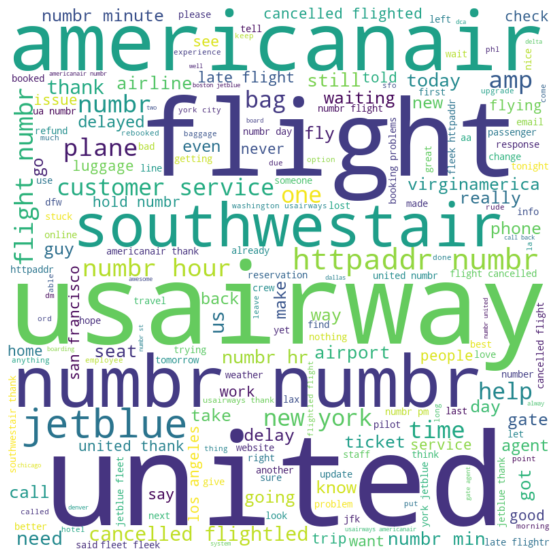

In [225]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text=whole_corpus
 
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
 
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud,  interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Textual labels conversion to numeric values

And the very last to do before training classifiers is to encode text labels into numeric labels. Some classifiers may not accept textual labels.

In [226]:
possible_labels = df.airline_sentiment.unique()
possible_labels

array(['neutral', 'positive', 'negative'], dtype=object)

In [227]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

# We can refer to this mapping later
label_dict

{'neutral': 0, 'positive': 1, 'negative': 2}

In [228]:
df['label'] = df.airline_sentiment.replace(label_dict)

<ipython-input-228-fb2c7dedc05a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.airline_sentiment.replace(label_dict)


In [229]:
df

,text_loc,airline_sentiment,contains_link,contains_number,contains_hashtag,cleaned_text,label
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,NO,NO,NO,virginamerica said,0
1,@VirginAmerica plus you've added commercials t...,positive,NO,NO,NO,virginamerica plus added commercials experience,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,NO,NO,NO,virginamerica today must mean need take anothe...,0
3,@VirginAmerica it's really aggressive to blast...,negative,NO,NO,NO,virginamerica really aggressive entertainment ...,2
4,@VirginAmerica and it's a really big bad thing...,negative,NO,NO,NO,virginamerica really big bad thing,2
...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,NO,NO,NO,americanair thank got different flight chicago,1
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,NO,YES,YES,americanair leaving numbr minutes late flight ...,2
14637,@AmericanAir Please bring American Airlines to...,neutral,NO,NO,NO,americanair please bring american airlines numbr,0
14638,"@AmericanAir you have my money, you change my ...",negative,NO,NO,NO,americanair money change flight answer phones ...,2


## Latent Semantic Analysis (LSA) visualization

Latent Semantic Analysis is a tool for grouping documents with similar meanings. We can use it to visualize the current dataset.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    df.cleaned_text, df.label, test_size=0.2, random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1, 1), binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

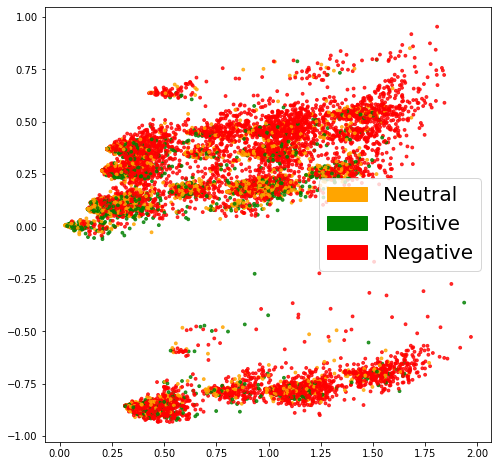

In [85]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','green', "red"]
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Neutral')
            blue_patch = mpatches.Patch(color='green', label='Positive')
            green_patch = mpatches.Patch(color='red', label='Negative')
            plt.legend(handles=[orange_patch, blue_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

It seems like the data is not that easy to divide - but let's see. This is an image with heacily reduced dimensionality. 

# Model training

In this section, we are going to train and evaluate different classifiers. Keep in mind that the dataset is very messy and we shouldn't expect astonishing performance improvement.

## Comparing with baseline

Firstly, let's use the same classifier and its configuration, so we can see how our processing and feature engineering changed the accuracy.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    df.cleaned_text, df.airline_sentiment, test_size=0.2, random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1, 1), binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [87]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train_counts, y_train)
y_predicted_counts = mnb.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.776, precision = 0.767, recall = 0.776, f1 = 0.769


In [88]:
scores = cross_val_score(mnb, X_train_counts, y_train, cv=5)

In [89]:
scores.mean()

0.7610952462947516

In [ ]:
#old score: 0.7596467191733065

Ok... using the same classifier (and its parameters) as before, we have a tiny improvement but all our preprocessing doesnt seem to have helped much

### Using different vectorizer

Let's consider a different vectorizer.

In [90]:
count_vectorizer = TfidfVectorizer(ngram_range=(1,1))


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

mnb = MultinomialNB()
y_pred = mnb.fit(X_train_counts, y_train)
y_predicted_counts = mnb.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.724, precision = 0.735, recall = 0.724, f1 = 0.679


In [91]:
scores = cross_val_score(mnb, X_train_counts, y_train, cv=5)
scores.mean()

0.7168016604760339

It seems like the TD-IDF doesn't work well in this case. We will stick to the countvectorizer because it gives us a bit better results. 

### Modifying vectorizer parameters

Let's play around with the parameters of the vectorizer before we tweak the classifier and increase the n-gram range. N-grams are joints of n-consecutive words. The range specifies the minimum and the maximum number of words.

In [94]:
count_vectorizer = CountVectorizer(ngram_range=(1,2) ,binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
y_pred = mnb.fit(X_train_counts, y_train)
y_predicted_counts = mnb.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.742, precision = 0.748, recall = 0.742, f1 = 0.704


In [95]:
scores = cross_val_score(mnb, X_train_counts, y_train, cv=5)
scores.mean()

0.7534106249296519

Increasing the n-gram range also doesn't increase the performance of the classifier. 

## Using Logistic Regression

Let's try out another classifier - Logistic Regression.

In [96]:
count_vectorizer = CountVectorizer(ngram_range=(1,2) ,binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [97]:
clf = LogisticRegression(solver="newton-cg")
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [98]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.788, precision = 0.783, recall = 0.788, f1 = 0.784


In [99]:
scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean()

0.7768089804053988

Nice - logistic regression performs a bit better. 

### Searching for best hyper-parameters

As you know, there are hyper-parameters like the `C` parameter, `solver` or `penalty`. We can try to find the best parameters manually, but it is much better to perform the Grid Search. Let's run it! **Note: This may take a lot of time!**

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': np.linspace(0.1, 1, 5), "solver":["newton-cg"]}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(X_train_counts, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

In [100]:
clf = LogisticRegression(C=0.55, solver='newton-cg' )
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.789, precision = 0.783, recall = 0.789, f1 = 0.784


In [101]:
scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean()

0.7775857725022604

## SVM

We will use several configurations for SVM.

In [102]:
from sklearn import svm
clf = svm.SVC()

clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.766, precision = 0.761, recall = 0.766, f1 = 0.761


In [103]:
scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean()

0.7550502294745678

In [104]:
clf = svm.SVC(kernel="poly", degree=2)

clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.712, precision = 0.710, recall = 0.712, f1 = 0.659


In [105]:
clf = svm.SVC(kernel="linear")

clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.762, recall = 0.761, f1 = 0.761


Again, we can try to find best parameters for SVM using the Grid Search.

In [ ]:
parameters = {'C': np.linspace(0.1, 5, 5), "kernel":["rbf"]} 
grid_search = GridSearchCV(svm.SVC(), parameters)
grid_search.fit(X_train_counts, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

In [109]:
clf = svm.SVC(kernel="linear", C = 0.1)

clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.780, precision = 0.774, recall = 0.780, f1 = 0.776


In [110]:
scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean()

0.7689521319853333

## Train-test split modification
Another approach is to modify the train-test split. 

### Size changes
Let's make the training set larger and add the stratify parameter.

In [111]:
# increasing training set size

X_train, X_test, y_train, y_test = train_test_split(df.cleaned_text, df.airline_sentiment, test_size=0.1,
                                                    random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1, 2), binary=True)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

clf = LogisticRegression(C=0.325, solver='newton-cg')
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" %
      (accuracy, precision, recall, f1))


scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean()  # no big difference - small overfitting on training set

accuracy = 0.780, precision = 0.774, recall = 0.780, f1 = 0.774


0.7820414428242517

### Resampling
For numerical data we could try resampling, e.g. Over- or undersampling or SMOTE. However, oversampling does not work with textual data because it is impossible for a computer to replicate human language, and with undersampling we would lose a lot of data

# Conclusion

Let's say this is our final model.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_text, df.airline_sentiment, test_size=0.2,
                                                    random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1, 2), binary=True)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

clf = LogisticRegression(C=0.325, solver='newton-cg')
clf.fit(X_train_counts, y_train)

scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean() 

0.7774130982011014

It seems like with linear classifiers we will not get much more than 78% accuracy out of it. 

### Confusion matrix
Of course one should also look at the misclassification. We will use the 3x3 confusion matrix to get some insights.

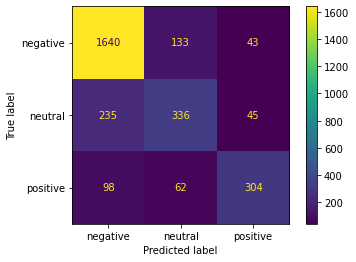

In [125]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test_counts, y_test) 
plt.show()

### Words with strong influence

Let's inspect which particular words have the highest influence on the classification decision for each class.

In [126]:
weights_dict = {}
weights_dict["feature"] = count_vectorizer.get_feature_names()
for class_num in range(3):
    weights_dict[clf.classes_[class_num]] = clf.coef_[class_num]

features_weights = pd.DataFrame(weights_dict)

In [127]:
features_weights.sort_values(by="negative", ascending=False).head(10)

,feature,negative,neutral,positive
68931,worst,1.290998,-0.614045,-0.676952
14854,delayed,1.113467,-0.717437,-0.396031
35569,luggage,0.973324,-0.553786,-0.419538
14696,delay,0.970378,-0.677024,-0.293353
27863,hold,0.968147,-0.349890,-0.618257
28642,hour,0.942432,-0.487128,-0.455304
40165,nothing,0.921818,-0.450741,-0.471077
28793,hours,0.912698,-0.401493,-0.511205
56681,stuck,0.884395,-0.465470,-0.418925
13685,customers,0.878015,-0.793199,-0.084816


In [128]:
features_weights.sort_values(by="neutral", ascending=False).head(10)

,feature,negative,neutral,positive
27707,hi,-0.495087,0.704959,-0.209872
47493,question,-0.467643,0.649270,-0.181627
46279,possible,-0.372212,0.622958,-0.250746
46118,policy,-0.033040,0.602650,-0.569610
9832,chance,-0.337558,0.601425,-0.263868
5057,atlanta,-0.455677,0.576287,-0.120610
54855,southwestair get,-0.376720,0.574345,-0.197625
5314,australia,-0.400690,0.548042,-0.147352
16365,dm,-0.125240,0.545819,-0.420579
50961,saw,-0.434183,0.544524,-0.110341


In [129]:
features_weights.sort_values(by="positive", ascending=False).head(10)

,feature,negative,neutral,positive
58499,thank,-1.399512,-0.625506,2.025018
58744,thanks,-1.151568,-0.550233,1.701800
25815,great,-0.777182,-0.849482,1.626663
5579,awesome,-0.828837,-0.639820,1.468657
2387,amazing,-0.818603,-0.497695,1.316299
35291,love,-0.939655,-0.303307,1.242962
6976,best,-0.581491,-0.584055,1.165546
59598,thx,-0.507527,-0.601088,1.108614
18698,excellent,-0.600577,-0.428519,1.029096
4377,appreciate,-0.546596,-0.375045,0.921641


Let's see what the model got wrong

In [130]:
y_df = pd.DataFrame({"text": X_test, "real target": y_test, "predicted target": y_predicted_counts})

In [132]:
wrong = y_df[y_df["real target"] != y_df["predicted target"]]

In [133]:
wrong.to_csv("wrong_predictions_airline.csv")

Note: you need to modify the code so it shows the whole text and not the preprocessed one

# Further ideas

However, if you are brave enough to continue working with this dataset...

### What happens if we delete the airline info from the tweets so that they don't influence them?

In [230]:
stop_words = list(stop_words)

# Let's remove "jetblue" as well (it replaces "delta" tweets - check the beginning of this notebook).
stop_words.extend(["virginamerica", "united", "delta", "usairways", "americanair", "southwestair", "jetblue"])  
stop_words = set(stop_words)

In [231]:
df_no_airlines = df.copy(deep=True)
df_no_airlines["cleaned_text"] =df_no_airlines.text_loc.swifter.apply(preprocess)

Let's visualize what are the most frequent words in the dataset after this change.

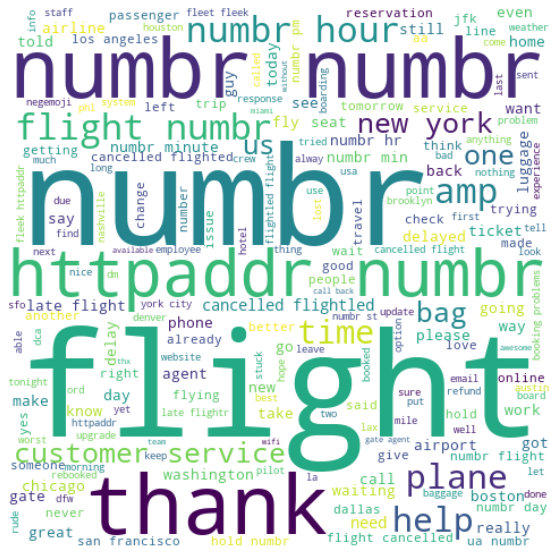

In [234]:
app_desc_clean_list = df_no_airlines["cleaned_text"].tolist()
whole_corpus = " ".join(app_desc_clean_list)

# Create a list of word
text=whole_corpus
 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, background_color='white').generate(text)
 
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud,  interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [233]:
X_train, X_test, y_train, y_test = train_test_split(df_no_airlines.cleaned_text, df_no_airlines.airline_sentiment, test_size=0.2,
                                                    random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1, 2), binary=True)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [235]:
clf = LogisticRegression(C=0.325, solver='newton-cg' )
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean()

accuracy = 0.789, precision = 0.783, recall = 0.789, f1 = 0.783


0.7757723755407021

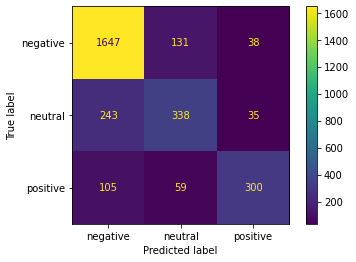

In [236]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test_counts, y_test) 
plt.show()

So now the classifier makes fewer mislabels as neutral if something was negative but mislabels neutrals more often as negative. Although it has better accuracy on negatives, on positives the accuracy is lower. However, as we can see, the airline has no significant impact on the sentiment. 

### What happens if we change the problem into the binary classification (negative vs non-negative)?

Let's approach this as a business problem: your client (an airline) wants to identify negative reviews so it can improve their operations. It does not care about neutral reviews given these are mainly questions.

In [237]:
# Previous labels: 0 - neutral, 1 - positive, 2 - negative
# New labels: 1 - non-negative, 2 negative
df["binary_label"] = df.label.apply(lambda x: 1 if x == 0 else x)
df["binary_airline_sentiment"] = df.airline_sentiment.apply(lambda x: "positive" if x == "neutral" else x)

<ipython-input-237-16c680eb7dfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["binary_label"] = df.label.apply(lambda x: 1 if x == 0 else x)
<ipython-input-237-16c680eb7dfb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["binary_airline_sentiment"] = df.airline_sentiment.apply(lambda x: "positive" if x == "neutral" else x)


In [238]:
df

,text_loc,airline_sentiment,contains_link,contains_number,contains_hashtag,cleaned_text,label,binary_label,binary_airline_sentiment
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,NO,NO,NO,virginamerica said,0,1,positive
1,@VirginAmerica plus you've added commercials t...,positive,NO,NO,NO,virginamerica plus added commercials experience,1,1,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral,NO,NO,NO,virginamerica today must mean need take anothe...,0,1,positive
3,@VirginAmerica it's really aggressive to blast...,negative,NO,NO,NO,virginamerica really aggressive entertainment ...,2,2,negative
4,@VirginAmerica and it's a really big bad thing...,negative,NO,NO,NO,virginamerica really big bad thing,2,2,negative
...,...,...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,NO,NO,NO,americanair thank got different flight chicago,1,1,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,NO,YES,YES,americanair leaving numbr minutes late flight ...,2,2,negative
14637,@AmericanAir Please bring American Airlines to...,neutral,NO,NO,NO,americanair please bring american airlines numbr,0,1,positive
14638,"@AmericanAir you have my money, you change my ...",negative,NO,NO,NO,americanair money change flight answer phones ...,2,2,negative


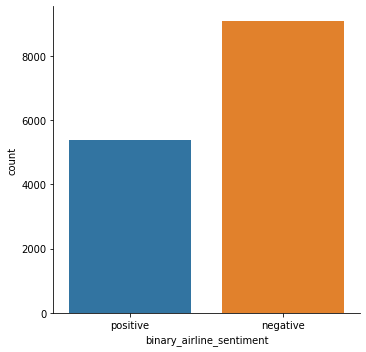

In [239]:
sns.catplot(x="binary_airline_sentiment", kind="count", data=df)

Now the dataset is much less imbalanced. Although it could be downsampled or oversampled, we will not change it for now.

In [240]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_text, df.binary_airline_sentiment, test_size=0.1, 
                                                                                random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1,1),binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

clf = LogisticRegression(C=0.325, solver='newton-cg')
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean() 

accuracy = 0.829, precision = 0.828, recall = 0.829, f1 = 0.828


0.8270913277052955

82%! As you can see, even on the first attempt we can get a much higher score. However, we had to pay for it by removing a class and transforming the task into a binary classification task. We can also try to visualize it using the t-SNE LSA graph.

In [241]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_text, df.binary_label, test_size=0.2, 
                                                                                random_state=40)
count_vectorizer = CountVectorizer(ngram_range=(1,1),binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

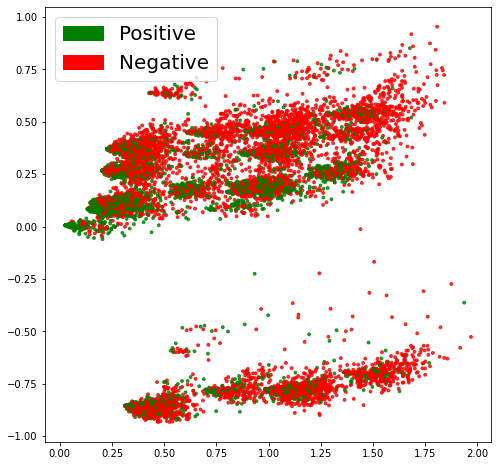

In [145]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['green', "red"]
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            blue_patch = mpatches.Patch(color='green', label='Positive')
            green_patch = mpatches.Patch(color='red', label='Negative')
            plt.legend(handles=[blue_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

---

### What happens if we use descriptions of emojis as additional features?

The `emoji` python package contains descriptions of each emoji. Since these descriptions often express emotions ("**sad** face", "**happy** face"), we can try to use them instead of marking tweets containing negative emojis. Of course, in our case emojis are present in an extremely small number of tweets, so the improvement won't be significant. However, in other applications, it may result in better performance. Let's see how it works with the following example.

In [242]:
def emojis_meaning(text):
    result = ""
    emojis =  ''.join(c for c in text if c in emoji.UNICODE_EMOJI['en'])
    for emo in emojis:
        result += re.sub(r'_', " ", emoji.demojize(emo)[1:-1]) + " "
    return result

In [243]:
emojis_meaning("😀👍")

'grinning face thumbs up '

In [244]:
emojis_meaning("@VirginAmerica 👍 Need to start flying to @KCIAirport .  😊😀😃😄")

'thumbs up smiling face with smiling eyes grinning face grinning face with big eyes grinning face with smiling eyes '

In [245]:
df['emojis_meaning'] = df.text_loc.apply(emojis_meaning)

<ipython-input-245-9d70e5512b2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emojis_meaning'] = df.text_loc.apply(emojis_meaning)


Let's continue with the binary classification task

In [247]:
df

,text_loc,airline_sentiment,contains_link,contains_number,contains_hashtag,cleaned_text,label,binary_label,binary_airline_sentiment,emojis_meaning
0,@VirginAmerica What @dhepburn said. nolocation...,neutral,NO,NO,NO,virginamerica said,0,1,positive,
1,@VirginAmerica plus you've added commercials t...,positive,NO,NO,NO,virginamerica plus added commercials experience,1,1,positive,
2,@VirginAmerica I didn't today... Must mean I n...,neutral,NO,NO,NO,virginamerica today must mean need take anothe...,0,1,positive,
3,@VirginAmerica it's really aggressive to blast...,negative,NO,NO,NO,virginamerica really aggressive entertainment ...,2,2,negative,
4,@VirginAmerica and it's a really big bad thing...,negative,NO,NO,NO,virginamerica really big bad thing,2,2,negative,
...,...,...,...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,NO,NO,NO,americanair thank got different flight chicago,1,1,positive,
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,NO,YES,YES,americanair leaving numbr minutes late flight ...,2,2,negative,
14637,@AmericanAir Please bring American Airlines to...,neutral,NO,NO,NO,americanair please bring american airlines numbr,0,1,positive,
14638,"@AmericanAir you have my money, you change my ...",negative,NO,NO,NO,americanair money change flight answer phones ...,2,2,negative,


Let's train the classifier!

In [254]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_text, df.binary_airline_sentiment, test_size=0.1, 
                                                                                random_state=40, stratify=df.binary_airline_sentiment)
count_vectorizer = CountVectorizer(ngram_range=(1,2),binary=True)


X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

clf = LogisticRegression(C=0.325, solver='newton-cg' )
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


scores = cross_val_score(clf, X_train_counts, y_train, cv=5)
scores.mean() 

accuracy = 0.842, precision = 0.841, recall = 0.842, f1 = 0.841


0.8252494244052186

As you can see,it does not make a difference, which is not surprising since emojis are only in about 1% of all tweets

## This is the end of Notebook 6

Feel free to experiment with this dataset more! If you are interested in the most efficient algorithms developed to deal with this problem, the airline classification dataset has been used by some researchers and you can find some papers about it online. However, it should be noted, that these researchers did not engage with the data a lot and just tested algorithms on the raw data, which is NOT the way to deal with textual data.